# Assignment 2 - Research Track 2

Second assignment for Research Track 2 course, done by **Vinícius Ferreira (S5646764)**.

This notebook refers to the second assignment done on Research Track 1 course, tasked with creating a notebook to replace the user interface on `node_a`.

Widgets are also going to be used, mainly for knowing:
* Handling the motion of the robot in the environment
* The positions of the robot and target, in a plot form (with `FuncAnimation`)
* Targets set/cancelled in the environment (distance, goal and quantity)
* Distance of the closest obstacle in a text box (if using the laser scanner, then a plot is needed)

## Modules

In [1]:
#! /usr/bin/env python3

import rospy
import os
import actionlib
import actionlib.msg
from vinicius_assignment_2_rt1.msg import node_a_msg
from assignment_2_2022.msg import *
from geometry_msgs.msg import Twist
from std_msgs.msg import Bool
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from tf import transformations
from std_srvs.srv import *
import time

import ipywidgets as widgets
import IPython.display
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import math
import jupyros as jr
from jupyros.ros1 import ros3d

%matplotlib widget

## Initialization

In [2]:
rospy.init_node('node_a')

## Variables initialization

In [3]:
global position_, yaw_, pose_, twist_msg, pub_a, pub_twist, msg_custom, cmd_widget, goal_send, reached_goals, cancelled_goals
twist_msg = Twist()
msg_custom = node_a_msg()
cmd_widget = Twist()
goal_send = assignment_2_2022.msg.PlanningGoal() 

reached_goals = 0
cancelled_goals = 0

## Functions

In [4]:
def clbk_odom(msg):
    # position
    position_ = msg.pose.pose.position
    pose_ = msg.pose.pose

    # yaw
    quaternion = (
        msg.pose.pose.orientation.x,
        msg.pose.pose.orientation.y,
        msg.pose.pose.orientation.z,
        msg.pose.pose.orientation.w)
    euler = transformations.euler_from_quaternion(quaternion)
    yaw_ = euler[2]
    
    msg_custom = node_a_msg()
    msg_custom.x = position_.x
    msg_custom.y = position_.y
    msg_custom.vel_x = msg.twist.twist.linear.x
    msg_custom.vel_y = msg.twist.twist.linear.y
    pub_a.publish(msg_custom)
    
def stp_robot():
    twist_msg = Twist()
    twist_msg.linear.x = 0
    twist_msg.angular.z = 0
    pub_twist.publish(twist_msg)

## Topics, services and actions

In [5]:
pub_twist = rospy.Publisher('/cmd_vel', Twist, queue_size=1)
sub_odom = rospy.Subscriber('/odom', Odometry, clbk_odom)
pub_a = rospy.Publisher('/node_a_info', node_a_msg, queue_size=1)

# pub_twist = jr.publish('/cmd_vel', Twist)
# sub_odom = jr.subscribe('/odom', Odometry, clbk_odom)
# pub_a = jr.publish('/node_a_info', node_a_msg)

## User interface

Definition of the functions

In [6]:
def forward_command():
    global cmd_widget, pub_twist
    
    cmd_widget.linear.x += 0.5
    pub_twist.publish(cmd_widget)
    
def reverse_command():
    cmd_widget.linear.x -= 0.5
    pub_twist.publish(cmd_widget)
    
def turn_left_command():
    cmd_widget.angular.z -= 0.1
    pub_twist.publish(cmd_widget)

def turn_right_command():
    cmd_widget.angular.z += 0.1
    pub_twist.publish(cmd_widget)
    
def stop_command():
    cmd_widget.linear.x = 0.0
    cmd_widget.angular.z = 0.0
    pub_twist.publish(cmd_widget)


Buttons definition

In [7]:
button_forward = widgets.Button(description='V+',
                                layout=widgets.Layout(width = '50px', height = '50px', grid_area = 'b_up'),
                                style=widgets.ButtonStyle(button_color='green'))

button_reverse = widgets.Button(description='V-',
                                layout=widgets.Layout(width = '50px', height = '50px', grid_area = 'b_down'),
                                style=widgets.ButtonStyle(button_color='green'))

button_left = widgets.Button(description='<-',
                              layout=widgets.Layout(width = '50px', height = '50px', grid_area = 'b_left'),
                              style=widgets.ButtonStyle(button_color='yellow'))

button_right = widgets.Button(description='->',
                             layout=widgets.Layout(width = '50px', height = '50px', grid_area = 'b_right'),
                             style=widgets.ButtonStyle(button_color='yellow'))

button_stop = widgets.Button(description='X',
                             layout=widgets.Layout(width = '50px', height = '50px', grid_area = 'b_stop'),
                             style=widgets.ButtonStyle(button_color='red'))

Adding the functions to the buttons

In [8]:
button_forward.on_click(forward_command)
button_reverse.on_click(reverse_command)
button_left.on_click(turn_left_command)
button_right.on_click(turn_right_command)
button_stop.on_click(stop_command)

In [9]:
layout_buttons = widgets.Layout(width = '60%',
                                grid_template_columns = '50px 50px 50px',
                                grid_template_rows = 'auto auto auto',
                                grid_gap = '12px 12px',
                                grid_template_areas = 
                                ''' "  .     b_up     .   "
                                    "b_left b_stop b_right"
                                    "  .    b_down    .   " ''')


widgets.GridBox(children = [button_forward, button_left, button_stop, button_right, button_reverse],
                layout = layout_buttons)


GridBox(children=(Button(description='V+', layout=Layout(grid_area='b_up', height='50px', width='50px'), style…

## Main code

Goal to be sent to the action server

In [10]:
in_var_x = widgets.FloatText(description = 'X = ', 
                             layout = widgets.Layout(height = 'auto', width = '150px'))
in_var_y = widgets.FloatText(description = 'Y = ',
                             layout = widgets.Layout(height = 'auto', width = '150px'))

display('Input the goal coordinates: ', in_var_x, in_var_y)

button_goal = widgets.Button(description = 'Send goal')
button_goal_out = widgets.Output()
display(button_goal, button_goal_out)

def button_clicked(btn):
    with button_goal_out:
        button_goal_out.clear_output()
        print("Robot deployed to goal!")
        goal_send.target_pose.pose.position.x = in_var_x.value
        goal_send.target_pose.pose.position.y = in_var_y.value
        print("Goal set as x = ", goal_send.target_pose.pose.position.x, "| y = ", goal_send.target_pose.pose.position.y)
        
button_goal.on_click(button_clicked)


'Input the goal coordinates: '

FloatText(value=0.0, description='X = ', layout=Layout(height='auto', width='150px'))

FloatText(value=0.0, description='Y = ', layout=Layout(height='auto', width='150px'))

Button(description='Send goal', style=ButtonStyle())

Output()

In [26]:

act_c_bug = actionlib.SimpleActionClient('/reaching_goal_bug', assignment_2_2022.msg.PlanningAction)
act_c_bug.wait_for_server()

act_c_point = actionlib.SimpleActionClient('/reaching_goal_point', assignment_2_2022.msg.PlanningAction)
act_c_point.wait_for_server() # Waiting for the action server
   
act_c_c = actionlib.SimpleActionClient('/reaching_goal_c', assignment_2_2022.msg.PlanningAction)
act_c_c.wait_for_server() # Waiting for the action server

act_c_bug.send_goal(goal_send)
act_c_point.send_goal(goal_send)
act_c_c.send_goal(goal_send)

In [27]:
button_cancel = widgets.Button(description = 'Cancel goal')
button_cancel_out = widgets.Output()
display(button_cancel, button_cancel_out)

def button_clicked_cancel(btn):
    global cmd_widget, pub_twist, pub_goal, cancelled_goals
    with button_cancel_out:
        button_cancel_out.clear_output()
        print("Goal cancelled!")
        
        act_c_bug.cancel_all_goals()
        act_c_point.cancel_all_goals()
        act_c_c.cancel_all_goals()
        
        cmd_widget.linear.x = 0.0
        cmd_widget.angular.z = 0.0
        pub_twist.publish(cmd_widget)

        cancelled_goals += 1
        
        #act_c_bug.wait_for_result()
        #act_c_bug.get_result()

        
button_cancel.on_click(button_clicked_cancel)

Button(description='Cancel goal', style=ButtonStyle())

Output()

## Plots

Position of the robot and target

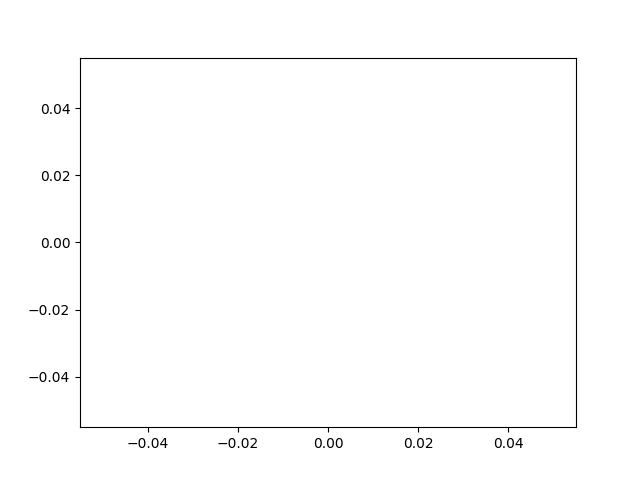

In [28]:

class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
        
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        self.ax.invert_xaxis()
        self.ax.invert_yaxis()
        return self.ln
    
    def odom_callback(self, msg):
        position_ = msg.pose.pose.position
        self.x_data.append(position_.x)
        self.y_data.append(position_.y)
        
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln

vis = Visualiser()
sub_plot_odom = rospy.Subscriber('/odom', Odometry, vis.odom_callback)

animation_pos_target = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show()

For the goals reached and cancelled

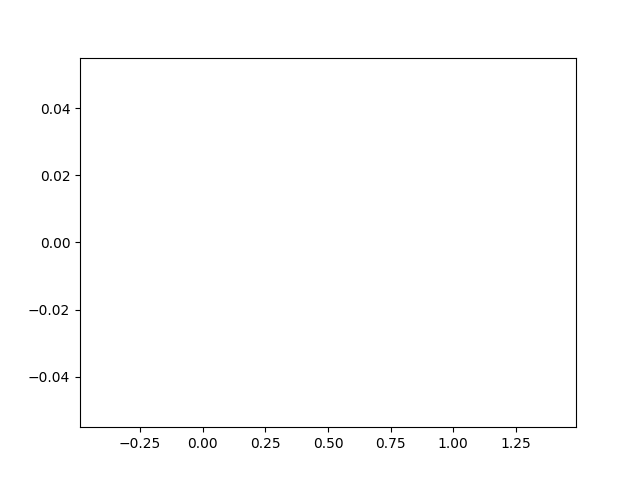

In [29]:
class VisualiserBar:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.bar_reached = self.ax.bar(0, 0, color='g')[0]
        self.bar_cancelled = self.ax.bar(1, 0, color='r')[0]
        
    def plot_init(self):
        self.ax.set_xticks([0, 1])
        self.ax.set_xticklabels(['Reached', 'Cancelled'])
        self.ax.set_ylim(0,5)
        return self.bar_reached, self.bar_cancelled
            
    def odom_callback(self, msg):
        global reached_goals, in_var_x, in_var_y
        position_ = msg.pose.pose.position
        if math.sqrt(pow(in_var_y.value - position_.y, 2) + pow(in_var_x.value - position_.x, 2)) < 0.5:
            reached_goals += 1
            in_var_x.value = 0
            in_var_y.value = 0
            return reached_goals
            
    def update_plot(self, frame):
        global reached_goals, cancelled_goals
        self.bar_reached.set_height(reached_goals)
        self.bar_cancelled.set_height(cancelled_goals)
        self.ax.set_ylim(0, 5+reached_goals)
        return self.bar_reached, self.bar_cancelled
    
vis_bar = VisualiserBar()
sub_plot_odom_2 = rospy.Subscriber('/odom', Odometry, vis_bar.odom_callback)

animation_goals = FuncAnimation(vis_bar.fig, vis_bar.update_plot, init_func=vis_bar.plot_init)
plt.show()

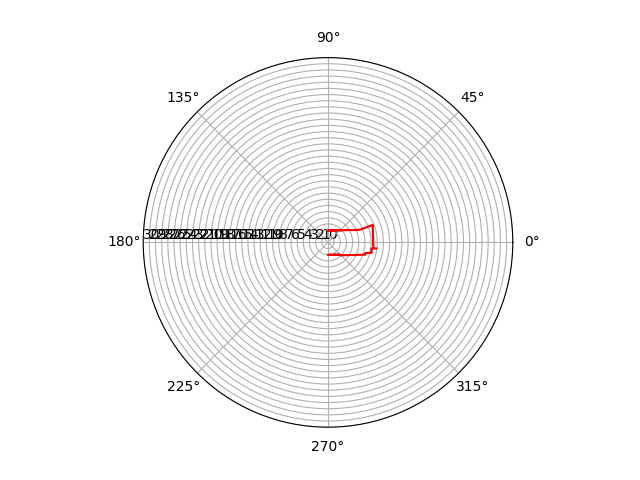

In [30]:
class VisuaLaser:
    def __init__(self):
        self.fig, self.ax = plt.subplots(subplot_kw={'projection': 'polar'})
        self.line, = self.ax.plot([], [], 'r-')
        self.angle_min = None
        self.angle_max = None
        self.angle_increment = None
        self.range_max = None
        self.ranges = None
        self.angles = None
        
    def plot_init(self):
        self.ax.set_rmax(self.range_max)
        self.ax.set_rticks(np.arange(0, self.range_max + 1, 1))
        self.ax.set_rlabel_position(180)
        self.ax.grid(True)
        return self.line
    
    def laser_callback(self, scan_msg):
        self.ranges = scan_msg.ranges
        self.angle_min = scan_msg.angle_min
        self.angle_max = scan_msg.angle_max
        self.angle_increment = scan_msg.angle_increment
        self.range_max = scan_msg.range_max
        
        self.ranges = np.array(self.ranges)

        self.ranges[np.isnan(self.ranges)] = self.range_max + 1

        self.angles = np.arange(self.angle_min, self.angle_max + self.angle_increment, self.angle_increment)
        x = self.ranges * np.cos(self.angles)
        y = self.ranges * np.sin(self.angles)

        self.line.set_data(self.angles, self.ranges)
        self.ax.set_rmax(self.range_max)
        self.ax.set_rticks(np.arange(0, self.range_max + 1, 1))
        self.ax.set_rlabel_position(180)
        self.ax.grid(True)
        return self.line

vis_laser = VisuaLaser()
scan_subscriber = rospy.Subscriber('/scan', LaserScan, vis_laser.laser_callback)

ani = animation.FuncAnimation(vis_laser.fig, vis_laser.plot_init, frames=1, blit=True)
ani = animation.FuncAnimation(vis_laser.fig, vis_laser.laser_callback, frames=1, interval=50, blit=True)

plt.show()
